In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

from recurrent_health_events_prediction.visualization.utils import plot_hidden_risk_over_time

# Define the color palette using Plotly's qualitative colors
plotly_colors = px.colors.qualitative.Plotly
sns.set_palette(plotly_colors)

In [2]:
file_dir = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival/cox_ph_with_hmm_log_time_covs_model"
filename = "last_events_with_hidden_states.csv"
filepath = os.path.join(file_dir, filename)
print("Loadding last events with hidden states from:", filepath)
last_events_hmm_features_df = pd.read_csv(filepath)

Loadding last events with hidden states from: /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival/cox_ph_with_hmm_log_time_covs_model/last_events_with_hidden_states.csv


In [3]:
last_events_hmm_features_df.columns

Index(['index', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ETHNICITY', 'INSURANCE', 'HOSPITALIZATION_DAYS',
       'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD',
       'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS',
       'PREV_DISCHTIME', 'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICIPATION_DAYS',

In [4]:
from recurrent_health_events_prediction.training.utils_hmm import sort_state_labels_by_severity

hidden_states_ordered = last_events_hmm_features_df["HEALTH_HIDDEN_RISK"].unique()
hidden_states_ordered = sort_state_labels_by_severity(hidden_states_ordered)
print("Unique hidden states ordered:", hidden_states_ordered)

Unique hidden states ordered: ['high', 'medium', 'low']


In [5]:
from recurrent_health_events_prediction.model.NextEventPredictionModel import NextEventPredictionModel
from recurrent_health_events_prediction.model.utils import load_model

model_name = "cox_ph_with_hmm_log_time_covs_model"
model_dir = f"/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival/{model_name}"
model_path = os.path.join(model_dir, f"{model_name}.pkl")
print(f"Loading model from {model_path}")
next_event_prediction_model: NextEventPredictionModel = load_model(model_path)

Loading model from /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival/cox_ph_with_hmm_log_time_covs_model/cox_ph_with_hmm_log_time_covs_model.pkl


In [6]:
next_event_prediction_model.model_config

{'model_name': 'Cox PH with HMM Log Time Covs Model',
 'base_hmm_name': 'hmm_mimic_time_log_normal_v1',
 'model_type': 'cox_ph',
 'save_model_path': '/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival',
 'strata_col': None,
 'event_col': 'READMISSION_EVENT',
 'event_id_col': 'HADM_ID',
 'duration_col': 'EVENT_DURATION',
 'cluster_col': None,
 'event_name': 'readmission',
 'features': ['AGE',
  'DISCHARGE_LOCATION_POST_ACUTE_CARE',
  'LOG_DAYS_IN_ICU',
  'CHARLSON_INDEX',
  'HAS_CONGESTIVE_HF',
  'PROB_HIDDEN_RISK_HIGH',
  'PROB_HIDDEN_RISK_MEDIUM',
  'PAST_COUNT_HIDDEN_RISK_HIGH',
  'PAST_COUNT_HIDDEN_RISK_MEDIUM',
  'PAST_COUNT_HIDDEN_RISK_LOW',
  'RANDOM_FEATURE'],
 'features_not_to_scale': ['HAS_CONGESTIVE_HF',
  'DISCHARGE_LOCATION_POST_ACUTE_CARE'],
 'evaluation_times': [30, 60, 90, 100],
 'main_evaluation_time': 30,
 'scale_features': True,
 'strata_remap': None,
 'model_params': {'penalizer': np.float64(0.13315789473684211),
  'l1_ratio': np.

In [7]:
random_state = 42
split_csv_path = "/workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/train_test_split.csv"
use_fixed_train_test_split = True
features_not_to_scale = next_event_prediction_model.model_config["features_not_to_scale"]
strata_col = next_event_prediction_model.model_config["strata_col"]
event_id_col = next_event_prediction_model.model_config["event_id_col"]
features_cols = next_event_prediction_model.model_config["features"]
duration_col = next_event_prediction_model.model_config["duration_col"]
event_col = next_event_prediction_model.model_config["event_col"]
cluster_col = next_event_prediction_model.model_config["cluster_col"]
scale_features = next_event_prediction_model.model_config['scale_features']

In [8]:
# Add a random feature for reference
from recurrent_health_events_prediction.training.train_traditional_survival_model import prepare_data

scale_features 

np.random.seed(random_state)  # Ensure reproducibility
last_events_hmm_features_df['RANDOM_FEATURE'] = np.random.rand(len(last_events_hmm_features_df))
cols = [event_id_col] + features_cols + [duration_col, event_col]
if strata_col:
    cols.append(strata_col)
if cluster_col:
    cols.append(cluster_col)

X = last_events_hmm_features_df[cols]

X_train, X_test = prepare_data(
    X,
    scale_features,
    duration_col,
    event_col,
    event_id_col,
    features_not_to_scale=features_not_to_scale,
    q_bins=1,
    use_fixed_train_test_split=use_fixed_train_test_split,
    split_csv_path=split_csv_path,
)

Using fixed train-test split from /workspaces/master-thesis-recurrent-health-events-prediction/data/mimic-iii-preprocessed/copd_heart_failure/multiple_hosp_patients/train_test_split.csv
Scaling features: ['AGE', 'LOG_DAYS_IN_ICU', 'CHARLSON_INDEX', 'PROB_HIDDEN_RISK_HIGH', 'PROB_HIDDEN_RISK_MEDIUM', 'PAST_COUNT_HIDDEN_RISK_HIGH', 'PAST_COUNT_HIDDEN_RISK_MEDIUM', 'PAST_COUNT_HIDDEN_RISK_LOW', 'RANDOM_FEATURE']


In [9]:
train_ids = X_train[event_id_col].unique()
test_ids = X_test[event_id_col].unique()

In [10]:
subject_id = 5901
mask = last_events_hmm_features_df["SUBJECT_ID"] == 5901
event_id_of_subject = last_events_hmm_features_df.loc[mask, "HADM_ID"].values[0].item()

In [11]:
event_id_of_subject

148246

In [12]:
if event_id_of_subject in train_ids:
    subject_df = X_train[X_train[event_id_col] == event_id_of_subject]
else:
    subject_df = X_test[X_test[event_id_col] == event_id_of_subject]

In [13]:
subject_df

,HADM_ID,AGE,DISCHARGE_LOCATION_POST_ACUTE_CARE,LOG_DAYS_IN_ICU,CHARLSON_INDEX,HAS_CONGESTIVE_HF,PROB_HIDDEN_RISK_HIGH,PROB_HIDDEN_RISK_MEDIUM,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_MEDIUM,PAST_COUNT_HIDDEN_RISK_LOW,RANDOM_FEATURE,EVENT_DURATION,READMISSION_EVENT
181,148246,0.727775,1,-0.423291,-0.214493,False,0.757865,-0.512714,0.848389,-0.472732,0.006726,-1.279279,57.747917,1


In [14]:
fig = next_event_prediction_model.plot_survival_function(subject_df, title="Survival Function for Subject 5901", duration_col = "EVENT_DURATION", event_col = "READMISSION_EVENT")

In [38]:
filepath = os.path.join("/workspaces/master-thesis-recurrent-health-events-prediction/assets/plots/eda/mimic", "survival_function_subject_5901.html")
fig.write_html(filepath)

In [15]:
next_event_prediction_model.feature_names_in_

['AGE',
 'DISCHARGE_LOCATION_POST_ACUTE_CARE',
 'LOG_DAYS_IN_ICU',
 'CHARLSON_INDEX',
 'HAS_CONGESTIVE_HF',
 'PROB_HIDDEN_RISK_HIGH',
 'PROB_HIDDEN_RISK_MEDIUM',
 'PAST_COUNT_HIDDEN_RISK_HIGH',
 'PAST_COUNT_HIDDEN_RISK_MEDIUM',
 'PAST_COUNT_HIDDEN_RISK_LOW',
 'RANDOM_FEATURE']

WARNING	shap:_kernel.py:__init__()- Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

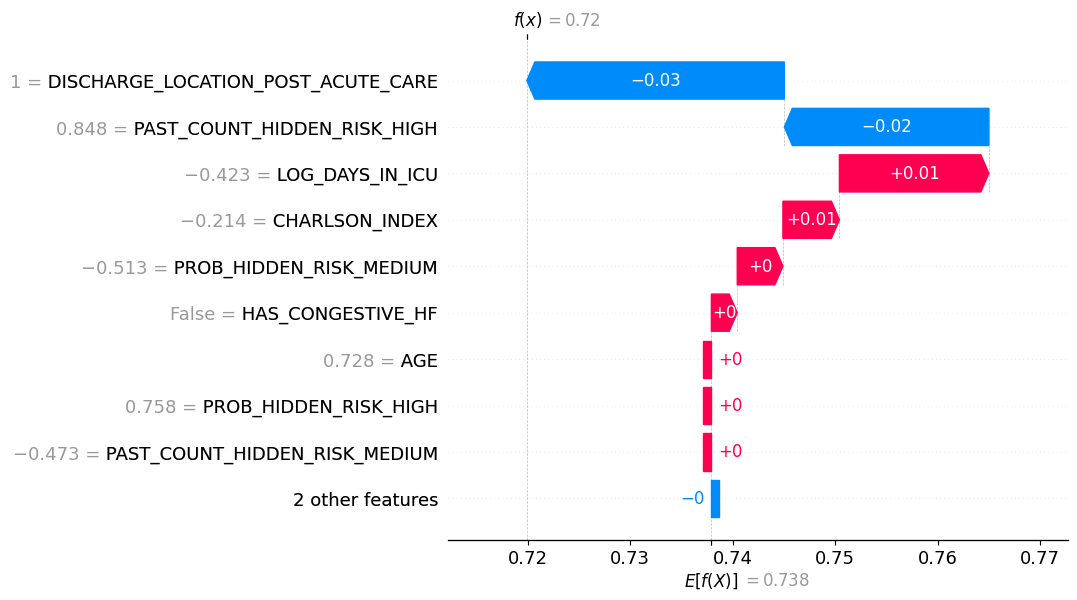

In [21]:
# Get SHAP values
from recurrent_health_events_prediction.model.explainers import explain_survival_model_prob, plot_waterfall

feature_names = next_event_prediction_model.feature_names_in_
X_explain = subject_df[feature_names]
X_background = X_train.iloc[:1000][feature_names]

shap_values, explainer = explain_survival_model_prob(
    next_event_prediction_model, X_background, X_explain, t=30
)
feature_names = next_event_prediction_model.feature_names_in_
plot_waterfall(explainer, X_explain, shap_values[0], feature_names)

In [ ]:
# Initialize the model with the configuration
next_event_model_km = NextEventPredictionModel(next_event_model_config['last_event_based'], model_type=SurvivalModelType.KAPLAN_MEIER)
next_event_model_km.model_name = "Kaplan Meier Estimator"